In [1]:
# from utils import * 

import os
os.chdir("../../scVI/")
os.getcwd()

import pickle
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
import gseapy as gp
save_path = '../CSF/Notebooks/'
from copy import deepcopy

In [2]:
celllabels = np.load(save_path + 'meta/celllabels.npy')
celltypes, labels = np.unique(celllabels,return_inverse=True)
isCSF = np.load(save_path + 'meta/isCSF.npy')
isMS = np.load(save_path + 'meta/isMS.npy')
genenames = pd.read_csv('../CSF/RFiles/genenames.csv',header=None)


In [3]:
celltypes

array(['B cell doublets', 'B1', 'B2', 'CD4', 'CD8a', 'CD8n', 'Gran',
       'MegaK', 'Mono', 'Mono Doublet', 'NK1', 'NK2', 'RBC', 'Tdg',
       'Tregs', 'contamination1', 'doublet', 'mDC1', 'mDC2', 'ncMono',
       'pDC', 'plasma'], dtype=object)

In [4]:
with open(save_path + 'DE/MSinPBMC.DEres.pkl', 'rb') as f:
    tissueDE,tissueDEclust = pickle.load(f)

In [5]:
len(tissueDEclust)

21

In [6]:
celltypes[tissueDEclust]

array(['B cell doublets', 'B1', 'B2', 'CD4', 'CD8a', 'CD8n', 'Gran',
       'MegaK', 'Mono', 'Mono Doublet', 'NK1', 'NK2', 'RBC', 'Tdg',
       'Tregs', 'contamination1', 'doublet', 'mDC2', 'ncMono', 'pDC',
       'plasma'], dtype=object)

In [7]:
clean = [1,2,3,4,5,6,7,8,10,11,13,14,17,18,19,20,21]
temp=[x in clean for x in tissueDEclust]
tissueDE = [tissueDE[i] for i,x in enumerate(temp) if x is True]
tissueDEclust = [tissueDEclust[i] for i,x in enumerate(temp) if x is True]

In [8]:
celltypes[tissueDEclust]

array(['B1', 'B2', 'CD4', 'CD8a', 'CD8n', 'Gran', 'MegaK', 'Mono', 'NK1',
       'NK2', 'Tdg', 'Tregs', 'mDC2', 'ncMono', 'pDC', 'plasma'],
      dtype=object)

In [9]:
print(celltypes[tissueDEclust])
print("total %i cell types"%len(tissueDE))

['B1' 'B2' 'CD4' 'CD8a' 'CD8n' 'Gran' 'MegaK' 'Mono' 'NK1' 'NK2' 'Tdg'
 'Tregs' 'mDC2' 'ncMono' 'pDC' 'plasma']
total 16 cell types


In [10]:
celltype = []
combinedDEres = []
for i,x in enumerate(celltypes[tissueDEclust]):
    temp  = pd.read_csv('../CSF/DE/wilcoxon/MannWhitneyU.norm.MSinPBMC.%s.csv'%x)
    fdr_wil = multipletests(temp['pvalue'],method='fdr_bh')
    temp.index = list(genenames[0])
    temp = pd.concat([temp,tissueDE[i]],axis=1,sort=True)
    temp = temp.sort_values(by='bayes1',ascending=False)
    combined = deepcopy(temp[['stat','pvalue','bayes1','bayes2','mean1','mean2','nonz1','nonz2','clusters']])
    combined['scVI_logFC'] = np.log(temp['scale1']/temp['scale2'])
    combined['norm_logFC'] = np.log(temp['norm_mean1']/temp['norm_mean2'])
    temp  = pd.read_csv('../CSF/EdgeR/MS_in_PBMC.batch_corrected.%s.edgeR.csv'%x)
    fdr_edgeR = multipletests(temp['PValue'],method='fdr_bh')
    temp.index = list(genenames[0])
    temp = temp[['logFC','logCPM','F','PValue']]
    combined = pd.concat([combined,temp],axis=1,sort=True)
    combined['fdr_wil'] = fdr_wil[1]
    combined['fdr_edgeR'] = fdr_edgeR[1]
    celltype.append(x)
    combinedDEres.append(combined)


/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [11]:
from pandas import ExcelWriter
import xlsxwriter


writer = pd.ExcelWriter(save_path + 'DE/MSinPBMC.xlsx', engine='xlsxwriter')
for i, x in enumerate(celltype):
    combinedDEres[i].to_excel(writer, sheet_name=str(x))
writer.close()


In [12]:
with open(save_path + 'DE/MSinPBMC.combined.DEres.pkl', 'wb') as f:
     pickle.dump((combinedDEres,celltype),f)

In [13]:
celltype

['B1',
 'B2',
 'CD4',
 'CD8a',
 'CD8n',
 'Gran',
 'MegaK',
 'Mono',
 'NK1',
 'NK2',
 'Tdg',
 'Tregs',
 'mDC2',
 'ncMono',
 'pDC',
 'plasma']

# Comparison

In [14]:
combined = pd.concat(combinedDEres)

In [15]:
from sklearn.metrics import roc_auc_score

def auc_score_threshold(gene_set, bayes_factor, gene_symbols):
    # put ones on the genes from the gene_set
    true_labels = np.array([g in gene_set for g in gene_symbols])
    estimated_score = np.abs(bayes_factor)
    indices = np.isfinite(estimated_score)
    return roc_auc_score(true_labels[indices], estimated_score[indices])


In [16]:
reflist = [['PBEF1', 'LILRA3', 'ADM', 'CDKN2D', 'NRG1', 'FPR1', 'AQP9', 'MAF', 'S100A12', 'SAMHD1', 'CDC42SE2', 'CYP27A1', 'IMPA2', 'FAM13A1', 'CSDE1', 'GK', 'ANG', 'BTBD14A', 'NINJ2', 'LPAR1', 'TRPM4', 'SASH1', 'RAB20', 'GLIPR1', 'COP1', 'DENND1A', 'CCNDBP1', 'PAPSS2', 'RAE1', 'S100A9', 'CRISPLD2', 'RNASE6', 'ASGR1', 'ZNF467', 'MMP25', 'HMOX1', 'BLVRB', 'FAM129B', 'PRKAR2A', 'AHNAK', 'TLR6', 'TAPBPL', 'IRAK3', 'CD14', 'RAB32', 'PLAUR', 'NFE2', 'NLRP3', 'NFIC', 'BRI3BP', 'SORT1', 'APLP2', 'FAM131A', 'TOP1', 'CDC42EP4', 'AP3S2', 'CD86', 'ENTPD1', 'GNA15', 'RNASE4', 'C1orf38', 'SLC30A1', 'CYBB', 'KCTD12', 'CPT1A', 'NPL', 'SIRPB1', 'SLC19A1', 'C11orf75', 'SOD2', 'SLC2A6', 'GCH1', 'ZNF358', 'BLVRA', 'IGF1R', 'CMTM4', 'GALNAC4S-6ST', 'SQRDL', 'PPFIBP2', 'FOSL2', 'HK2', 'GM2A', 'DAP3', 'HNMT', 'S100A4', 'CPD', 'EPHA3', 'FAM49A', 'MXD1', 'SERTAD3', 'PM227', 'ETS2', 'TSPO', 'LILRA2', 'FCN1', 'SKAP2', 'TBC1D2', 'CXCL1', 'RTN3', 'KIF1B', 'ST3GAL2', 'DNASE2', 'GPI', 'SPATA7', 'TIPARP', 'MICB', 'TKT', 'RIPK2', 'LILRB3', 'ADFP', 'CHP1', 'TNFRSF1B', 'PAK1', 'ARPC4', 'SSBP2', 'ZNF364', 'ARRB1', 'CASP1', 'HN1', 'S100A8', 'MYST1', 'ETV6', 'KCTD17', 'CAPN2', 'HAGH', 'TRIM8', 'IFT20', 'SCAMP1', 'AP3D1', 'MBD4', 'RNF44', 'ARHGAP25', 'CALM1', 'SKP2', 'C18orf8', 'HERC2', 'GOLGA3', 'KIAA0179', 'ST6GAL1', 'TTC3', 'ST3GAL5', 'TSEN2', 'ADARB1', 'SEPT2', 'ILF3', 'BRD8', 'PFKP', 'TMEM194', 'LY9', 'RFX5', 'SCD', 'TRAF3IP3', 'MAN2A2', 'MTF2', 'WDR91', 'CBX7', 'SLC20A1', 'NUP210', 'DHTKD1', 'ANKFY1', 'APBB1IP', 'DENND2D', 'GTF3C2', 'OSBPL7', 'SCYL3', 'MDC1', 'TRIM56', 'PRPF3', 'BTRC', 'FAM122C', 'DGKD', 'PARP2', 'HLA-DOA', 'ZNF23', 'SMARCA3', 'TSC2', 'HOM-TES-103', 'TRIM38', 'CHKB', 'ENOSF1', 'E2F5', 'FAIM3', 'MCM2', 'XPC', 'MDK', 'ALDH5A1', 'ZNF238', 'SYNJ2', 'NAT6', 'LDLRAP1', 'RPL10A', 'SIGIRR', 'BAT1', 'VAMP1', 'DDR1', 'ATM', 'AP1G2', 'PARC', 'TTLL3', 'TCF3', 'NPIP', 'EDN1', 'RHBDD3', 'SLC25A22', 'TMEM63A', 'PURA', 'CD22', 'PLCXD1', 'GOLGA8A', 'PPARD', 'SIRT4', 'CR2', 'NPR2', 'AKAP7', 'C17orf75', 'CCNT1', 'CNTNAP2'],
['TMEM176A', 'CHMP2A', 'TMEM176B', 'IFITM3', 'APEX1', 'MRI1', 'SAT1', 'LST1', 'COX6B1', 'DCXR', 'PYCARD', 'ALYREF', 'TYROBP', 'EIF6', 'AURKAIP1', 'PARK7', 'EDF1', 'NSD1', 'NOP10', 'COX4I1', 'ATP5D', 'STX10', 'UQCR10', 'CDC37', 'USE1', 'TRAPPC1', 'PSME1', 'CSNK2B', 'S100A11', 'PSENEN', 'GDI1', 'NEDD8', 'NDUFB10', 'C19orf43', 'TPI1P1',  'MRFAP1', 'CSTB', 'PRR13', 'S100A6', 'RHOG', 'COX6A1P2', 'MSRB2', 'MIEN1', 'TBCB', 'TMEM205', 'NME1', 'PSMA7', 'TFPT', 'ATP6V0E1', 'NACAP1', 'CFL1', 'FCGRT', 'HN1', 'SAT2', 'ATP5H', 'AIF1', 'CD33', 'SRP14', 'GMFG'],
['MBNL1','CSTF3','HNRNPA2B1','HNRNPH1','HNRNPH3','SRSF1','SCAF11','CELF1','CUGBP1','GEMIN6','PCBP1','POLR2J','SRSF3'],
['XRCC4', 'PRKCA', 'TAX1BP1', 'CDC42', 'PSMA1', 'PIAS1', 'PIK3CA', 'SAMHD1', 'CD83', 'TCF12', 'PURB', 'DUSP4', 'SP3', 'CXCR4', 'SP100', 'HMGB1', 'SOD2', 'BCL10', 'AIMP1', 'TIPARP', 'HMGB2', 'PELI1', 'TNFAIP3', 'RGS1', 'IFI44L', 'ITGAM', 'CD8A', 'CCL5', 'KLF13', 'CCR2', 'SASH3', 'SOS1', 'CD8B', 'CRTAM', 'TGFBR1', 'TOB2', 'FYN', 'CRKL', 'CD244', 'ITGB2', 'IKZF3', 'SEC24C', 'MYO1F', 'SPN', 'NFATC2', 'SIT1', 'IL16', 'TUBB', 'TNFSF14', 'LCP2'],
['LEF1', 'TCF3', 'SLAM', 'CTSK', 'CTSB', 'LTB', 'TRAF5', 'ITGAL', 'ITGB2', 'ITGB7', 'PIP5K', 'MAP4', 'MAPK6', 'MAP2K3', 'MAP3K8', 'MAP4K4', 'TRAF6', 'SCYA20', 'IL1RAP', 'IL1RN', 'TGFB1', 'SKI', 'SKIL', 'MADH7', 'NR4A1', 'NR4A2', 'TNF', 'TNFAIP6', 'TNFSF14', 'TNFRSF1B', 'TNFRSF4', 'NFKB1', 'NFKB2', 'NFKB1A', 'CCNG1', 'PDCD2', 'MAPK1', 'MAPK9', 'MAPK14', 'MAPK3K1', 'MAPK3K12', 'MAPK4K5'],
['STAC', 'GNG3', 'CASP1', 'ATP6S1', 'BAK1', 'TGFBR2', 'TCFL1', 'VAV2', 'POLR2G', 'TRAF4', 'IFNAR1', 'CYP2A6', 'C11ORF13', 'PNMT', 'SCYA24', 'NR2F1', 'ILF1', 'SCYA1', 'NFKB2', 'RAB11A', 'POLR2J', 'ING1', 'PEMT', 'IL1RL1', 'ATP1B3P1', 'PSMC6', 'IFNA16', 'P2Y5', 'MAP2K1', 'RIPK2', 'TGFB1', 'IL6R', 'GNA13', 'CYP1A2', 'ALDH7', 'TPR', 'CYP3A4', 'TNFAIP3', 'KARP1', 'IL10', 'IL12B', 'RAB7L1', 'AKAP11', 'ABCC5', 'BAG1', 'YWHAH', 'COX10', 'IRS4', 'VCAM1', 'ADCY7', 'BCD2', 'COX11', 'COX15', 'SGK', 'AKAP9', 'SLC1A1', 'OLE2', 'STIP1', 'AKAP2', 'AGTRL2', 'GABPB1', 'NRF', 'GNG2', 'MAPK13', 'KIAA0864', 'AKR1B1', 'ST1B2', 'GNAQ', 'AP1S2', 'CREB1', 'MAPKAPK3', 'ATF3', 'CPE', 'SGK2', 'RBL1', 'AVP', 'TCF17', 'SLC6A2', 'GHSR', 'NBS1', 'TERF1', 'HSPCA', 'ABCB7', 'ERBB4', 'TOP1', 'ATP6D', 'TOPBP1', 'HSP105B', 'TCFL5', 'ABCG2', 'TGFBR1', 'TCF8', 'PRKCN', 'ATP2C1', 'RUNX1', 'ALDH9', 'ATM', 'TNFSF10', 'MADH4', 'IL18R1', 'TSC22', 'CCR5', 'MADH2', 'ADH2', 'CD2', 'CDC2L5', 'CCNC', 'PPP3CB', 'KRAS2', 'IGF2', 'CDC42', 'GADD45A', 'NR3C1', 'DTR', 'IL2RB', 'NFKBIA', 'NR3C2', 'ABCB1', 'MX2', 'PDGFRA', 'HRAS', 'TFAP2C', 'TCF12', 'STAT1', 'EGFR', 'MIG', 'ITGB1', 'GNB1', 'KITLG', 'SCYB10', 'TGFB2', 'IRF2', 'TNFAIP6', 'PTPRC', 'GRO1', 'GRO2', 'SKIL', 'UGT2B4', 'NR5A2', 'RBBP4', 'ST13', 'CDC27', 'ARHI', 'NR4A2', 'MSH2', 'PRKCM', 'NOVA1', 'PCNA', 'RBBP1', 'MAP3K7', 'SF1R', 'SCYB5', 'EP300', 'IFI16', 'MERTK', 'RAP1A', 'PMS1', 'AADAC', 'JUN', 'CDC10', 'SMARCA3', 'CDC16', 'MSH6', 'ABCE1', 'TAF2F', 'ATRX', 'CSNK1A1', 'TCEB1L', 'PRKDC', 'GNG10', 'HDAC1', 'CDC25A', 'CYP17', 'ERCC3', 'GSTM3', 'GZMA', 'PECAM1', 'PRKCQ', 'RPC62', 'CFLAR', 'CRADD', 'ATP6H', 'NHP2L1', 'RPA1', 'HSPA1L', 'TRA@', 'EGF', 'ARHGDIB', 'IL16', 'PDCD8', 'TP53BP1', 'CHST4', 'RAB4', 'HSPA10', 'HDGF', 'NFATC3', 'MCM3', 'CASP10', 'CSNK2A2', 'CSNK2A1', 'CDK2', 'CYP4B1', 'FGF5', 'ISGF3G', 'SELL', 'PIM1', 'ADPRT', 'JAK1', 'RALB', 'TAF2D', 'SCYA18', 'GNB5', 'TNFRSF11A', 'TCF21', 'PRKCBP1', 'HSBP1', 'TPST2', 'CYP8B1', 'RBL2', 'SCYA13', 'BAG4', 'CYP3A5P1', 'GAPCENA', 'CHST2', 'ATP6B2', 'BRCA1', 'ABCB10', 'TTF1', 'SULTX3', 'PAK2', 'CYP4F2', 'POLR2H', 'RAB9', 'GS14', 'ATP2B3', 'CRYBA4', 'ABL2', 'CD79B', 'DOK1', 'CDC25B', 'CES1', 'CCND3', 'EPHX2', 'MAPK1', 'EPOR', 'PMM1', 'ERBB2', 'SCYA3', 'CYP21A2', 'PLCB2', 'NTF5', 'NFKBIE', 'PTPN7', 'DAXX', 'ABCF1', 'TNFRSF10C', 'IL17R', 'NPR2L', 'IL2RG', 'THRB', 'GJB1', 'CSF3', 'IL14', 'ABCB6', 'PSMC4', 'MYC', 'NR1I2', 'CYP2E', 'PTPN6', 'MST1R', 'SPIB', 'TNFRSF1A', 'ABCF2', 'SCYB14', 'E2F4', 'CDK4', 'TIMP3', 'NFRKB', 'TIM', 'SLC35A1', 'THY1', 'HSPA1A', 'CDK5R1', 'TAF2H', 'ATP7A', 'AFG3L2'],
['NR4A2', 'TCF8', 'CYP1A2', 'RGS14', 'CHST2', 'MAPK1', 'SMARCA3', 'TPST2', 'TCF17', 'HSPA1A', 'AGTRL2', 'TRAIL', 'TOP1', 'PTPN6', 'CCR5', 'CHST4', 'ERBB4', 'TCF21', 'ATP6V1B2', 'CREB1', 'ITGB1', 'COX15', 'MYC', 'BAG1', 'CDC16', 'SLC35A1', 'DAXX', 'TSC22', 'GABPB1', 'PARP'],
['IKKE', 'MAL', 'ZAP70', 'DPP4', 'ITGA6', 'NKTR', 'SCYE1', 'IL7R', 'PDE7A', 'ATM', 'TNFRSF7', 'DGKA', 'TRA@', 'NK4', 'PAFAH1B1', 'CCR7', 'SPTBN1', 'GOLGA4', 'SLC35A1', 'SPTAN1', 'PPP2R5C', 'TTC3', 'BAZ2B', 'XPC', 'ZNF148', 'TCF7', 'BCL2', 'ZNF43', 'HLA-DRA', 'CD83', 'PTP4A1', 'SCYA3', 'MADH7', 'TIMP1', 'PIK3R4', 'HSPA1A', 'DNAJA1', 'SERPINH2', 'SEC34', 'IFI30', 'JUN', 'H1F2', 'CKS2', 'DNTT', 'BRF1'],
['JUN', 'PDE3A', 'RB1', 'JUNB', 'FOS', 'JUND', 'MMP9', 'SOCS1', 'GNAI1', 'SMAD3', 'PANK4', 'STK38', 'PARP4', 'PDCD10', 'TP53', 'OR2W1', 'PLEKHF1', 'TRAF1', 'BRCA1', 'TBP'],
['ABCA5', 'AK5', 'ANKH', 'ANKRD20A2', 'APG7L', 'ATF1', 'AVO3', 'C14orf132', 'C1D', 'C1GALT1', 'C1orf103', 'C1orf22', 'C20orf155', 'C20orf17', 'C21orf45', 'C6orf105', 'CACYBP', 'CAMSAP1L1', 'CAMTA1', 'CAP350', 'CCNB1', 'CDK6', 'CETN3', 'CHM', 'CLIC5', 'CR1', 'CRBN', 'CRIPT', 'DC-UbP', 'DDX18', 'DDX58', 'DENR', 'DICER1', 'DLAT', 'DOCK8', 'EIF2S1', 'EIF5B', 'EPPK1', 'FAM13A1', 'FBXL17', 'FBXO45', 'FGFR1OP2', 'FLJ10707', 'FLJ20054', 'FLJ20125', 'FLJ20125', 'FLJ21657', 'FLJ22833', 'FLJ22833', 'FLJ44896', 'FUT8', 'FXYD5', 'G3BP', 'GCET2', 'GIMAP8', 'GOLPH3L', 'HCG8', 'HDHD1A', 'HNRPA2B1', 'HNRPD', 'HP1-BP74', 'HSPC138', 'IMAA', 'IMMP1L', 'INADL', 'ITGAV', 'ITPKB', 'KIAA0794', 'KIAA0804', 'KIAA1423', 'KIAA1618', 'KIAA1731', 'KIAA2026', 'KIF5C', 'LACTB2', 'LEF1', 'LNPEP', 'LOC129531', 'LOC134492', 'LOC283788', 'LOC284591', 'LOC284926', 'LOC285550', 'LOC492311', 'LRIG2', 'LRRN3', 'LRRN3', 'MALAT1', 'MAML2', 'MAML2', 'MAT2B', 'MCM3APAS', 'MCOLN3', 'MESDC1', 'MGC48625', 'MLLT2', 'MSI2', 'MSL3L1', 'NAPE-PLD', 'NDFIP1', 'NEK1', 'NRIP1', 'OBFC1', 'PALM2-AKAP2', 'PDCD5', 'PDE7A', 'PPP4R2', 'PREPL', 'PSME3', 'PTER', 'PTX1', 'RAB3GAP1', 'RAP2A', 'RFP2', 'RIF1', 'RNF146', 'RNF149', 'RNF32', 'RNPC2', 'RPL35A', 'RPS27L', 'RSBN1', 'SAC3D1', 'SCOC', 'SDAD1', 'SFRS5', 'SLC12A2', 'SLC25A36', 'SLC26A2', 'SLC35B3', 'SMC5L1', 'SMYD2', 'SNRPN', 'ST8SIA1', 'STAG2', 'STK4', 'SVH', 'TARSL2', 'TCEAL2', 'THAP5', 'TM7SF1', 'TMEM45B', 'TNFRSF17', 'TNRC6B', 'TPT1', 'TRAPPC6B', 'TRIM2', 'TRPM7', 'TSNAX', 'TTC14', 'TTLL5', 'UBE2V2', 'UBTF', 'USP31', 'USP46', 'XPO7', 'ZCCHC7', 'ZFP3', 'ZNF12', 'ZNF12', 'ZNF167', 'ZNF207', 'ZNF292', 'ZNF439']]

In [17]:
%%capture
res = []
for i,x in enumerate(combinedDEres):
    auc = []
    for l in reflist:
        a=auc_score_threshold(l, (x['bayes1']), list(x.index))
        b=auc_score_threshold(l, -np.log(list(x['PValue']+1e-20)), list(x.index))
        c=auc_score_threshold(l, -np.log(list(x['pvalue']+1e-20)), list(x.index))
        auc.append([a,b,c])
    res.append(auc)

In [18]:
for x in res[1]:
    print("%.3f\t%.3f\t%.3f"%(x[0],x[1],x[2]))

0.498	0.490	0.499
0.374	0.479	0.215
0.478	0.582	0.105
0.601	0.548	0.482
0.518	0.546	0.475
0.580	0.579	0.423
0.661	0.635	0.368
0.505	0.527	0.416
0.539	0.659	0.630
0.522	0.542	0.415


# GSEA

In [19]:
gmt = ['c7.all.v6.2.symbols.gmt',
       'Hemato.geneset.gmt',
       'cell_cycle_Tirosh.gmt',
       'chenling.gmt',
       'netPath.gmt',
       'codeset.gmt',
       'signatures_NY_private.gmt']
gmt = ['../CSF/signatures/'+x for x in gmt]

In [20]:
def DE_GSEA(filtered,gmt,celltypes,filename):
    gsea_res = []
    for x in filtered:
        if len(x)>0:
            res1 = gp.enrichr(gene_list=list(x.index),
                     gene_sets=['KEGG_2016'],
                     cutoff=0.5                    )
            res2 = gp.enrichr(gene_list=list(x.index),
                             gene_sets=gmt,
                             cutoff=0.5,
                             background=10266)
            res = pd.concat([res1.results,res2.results])
            res = res.sort_values(by='P-value')
            res['cluster'] = celltypes[list(x['clusters'])[0]]
            gsea_res.append(res.loc[res['Adjusted P-value']<0.05])
    gsea_res = pd.concat(gsea_res)
    gsea_res = gsea_res[['Adjusted P-value','Genes','Term','Overlap','cluster']]
    gsea_res.to_csv(filename)
    return(gsea_res)


# upregulated in MS

In [14]:
filtered = [x.loc[(x['fdr_wil']<0.2)&(x['fdr_edgeR']<0.2)& 
                  (x['bayes1']>0.3) &
                  (x['logFC']<0) & (x['norm_logFC']>0)] for x in combinedDEres]

DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)

DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]
DEgenes = DEgenes.sort_index()
DEgenes.to_csv(save_path+'DE/MSinPBMC.upregulated.relaxed.csv')

In [13]:
%%capture
# filtered_GSEA = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/MSinPBMC.upregulated.relaxed.GSEA.csv')

In [20]:
filtered = [x.loc[(x['fdr_wil']<0.05)&(x['fdr_edgeR']<0.05)& 
                  (x['bayes1']>0.5) &
                  (x['logFC']<0) & (x['norm_logFC']>0)] for x in combinedDEres]

DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)

DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]
DEgenes = DEgenes.sort_index()
DEgenes.to_csv(save_path+'DE/MSinPBMC.upregulated.csv')


In [24]:
%%capture
filtered_GSEA = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/MSinPBMC.upregulated.GSEA.csv')

# downregulated in MS

In [25]:

filtered = [x.loc[(x['fdr_wil']<0.2)&(x['fdr_edgeR']<0.2)& 
                  (x['bayes2']>0.3) &
                  (x['logFC']>0) & (x['norm_logFC']<0)] for x in combinedDEres]


DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)
DEgenes = DEgenes.sort_index()
DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]

DEgenes.to_csv(save_path+'DE/MSinPBMC.downregulated.relaxed.csv')

In [26]:
%%capture
filtered_GSEA = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/MSinPBMC.downregulated.relaxed.GSEA.csv')

In [27]:
filtered = [x.loc[(x['fdr_wil']<0.05)&(x['fdr_edgeR']<0.05)& 
                  (x['bayes2']>0.5) &
                  (x['logFC']>0) & (x['norm_logFC']<0)] for x in combinedDEres]
DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)
DEgenes = DEgenes.sort_index()
DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]
DEgenes.to_csv(save_path+'DE/MSinPBMC.downregulated.csv')

In [28]:
%%capture
filtered_GSEA = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/MSinPBMC.downregulated.GSEA.csv')

# visualizations

In [29]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt


%matplotlib inline

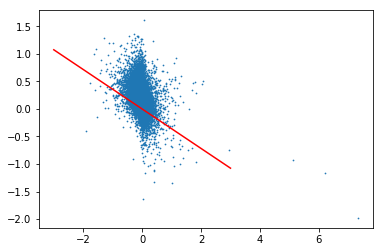

In [30]:
x = combinedDEres[3]['logFC']
y = combinedDEres[3]['scVI_logFC']
xrange = np.max(np.abs(x))
plt.scatter(x,y,s=.5)
cor = np.asarray(pd.concat([x,y],1).corr())[0,1]
plt.plot([-3,3],[-3*cor,3*cor],'r-')

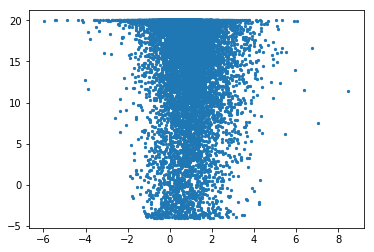

In [31]:
x = combinedDEres[1]['bayes1']
y = -np.log10(combinedDEres[1]['pvalue']*10026+1e-20)
xrange = np.max(np.abs(x))
plt.scatter(x,y,s=5)

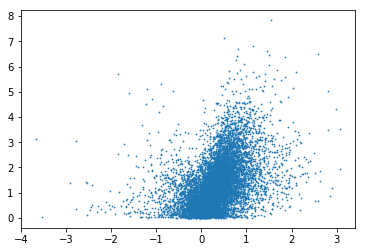

In [32]:
x = combinedDEres[0]['norm_logFC']
y = np.abs(combinedDEres[0]['bayes1'])
xrange = np.max(np.abs(x))
plt.scatter(x,y,s=0.5)